<a href="https://colab.research.google.com/github/thanachai-npr/CE888/blob/main/Assignment/MobileNet_for_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Import Libraies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras import regularizers
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
import cv2

In [3]:
##Connect our notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
## Using ImageDataGenerator to read images from directories
train = ImageDataGenerator(rescale=1./255, horizontal_flip = True, rotation_range = 20, validation_split=0.2)
test = ImageDataGenerator(rescale=1./255)

train_dataset = train.flow_from_directory('/content/drive/MyDrive/Training/Training', target_size = (224,224), batch_size = 32, class_mode = 'binary', seed = 6969, subset='training')
valid_dataset = train.flow_from_directory('/content/drive/MyDrive/Training/Training', target_size = (224,224), batch_size = 32, class_mode = 'binary', seed = 6969, subset='validation' )
test_dataset = test.flow_from_directory(('/content/drive/MyDrive/Test/Test'), target_size = (224,224), batch_size = 32, class_mode = 'binary')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [9]:
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dropout, Input, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import Model

# Download MobileNet model and set up input image size
IMG_SIZE = 224
img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

model = MobileNet(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
)
model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

In [16]:
## Fine tuning the layers after global_average_pooling2d
last_layer = model.get_layer('global_average_pooling2d').output
x = BatchNormalization()(last_layer)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', name='fc2')(x)
out = Dense(1, activation='sigmoid', name='output')(x)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-6]:
	layer.trainable = False
model.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [18]:
# Set callbacks function and compile the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
name = 'MobileNetV_model.h5'
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights= True),
    ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode='min')
]
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc']
              )

In [19]:
## Train phase
history = model.fit(train_dataset,
                               batch_size=32,
                               epochs=50, 
                               validation_data=valid_dataset,
                               callbacks = my_callbacks
                    )

Epoch 1/50
985/985 [==============================] - 28047s 28s/step - loss: 0.0962 - acc: 0.9679 - val_loss: 0.2796 - val_acc: 0.9484

Epoch 00001: val_loss improved from inf to 0.27960, saving model to MobileNetV_model.h5
Epoch 2/50
985/985 [==============================] - 449s 455ms/step - loss: 0.0291 - acc: 0.9891 - val_loss: 0.3089 - val_acc: 0.9496

Epoch 00002: val_loss did not improve from 0.27960
Epoch 3/50
985/985 [==============================] - 447s 454ms/step - loss: 0.0238 - acc: 0.9910 - val_loss: 0.3645 - val_acc: 0.9479

Epoch 00003: val_loss did not improve from 0.27960
Epoch 4/50
985/985 [==============================] - 447s 454ms/step - loss: 0.0198 - acc: 0.9924 - val_loss: 0.3518 - val_acc: 0.9455

Epoch 00004: val_loss did not improve from 0.27960
Epoch 5/50
985/985 [==============================] - 447s 453ms/step - loss: 0.0169 - acc: 0.9943 - val_loss: 0.3298 - val_acc: 0.9441

Epoch 00005: val_loss did not improve from 0.27960
Epoch 6/50
985/985 [===

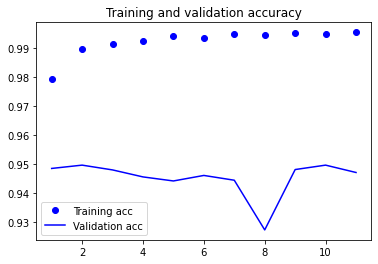

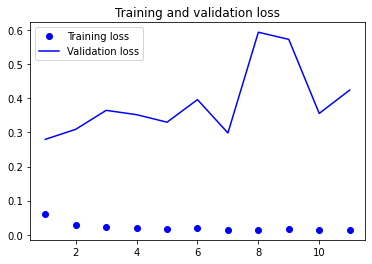

In [20]:
##Plot the graph of training phase

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
## Predict the value on test set
final_model = tf.keras.models.load_model(name)
pred = final_model.predict(test_dataset, verbose=1)
ypred = pred > 0.5
labels = test_dataset.classes

270/270 [==============================] - 27s 99ms/step


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

  #### This function prints and plots confusion matrix ####
  #### Reference : https://deeplizard.com/learn/video/km7pxKy4UHU ####
  plt.imshow(cm, interpolation ='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np,newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion Matrix without Normalization")
  print(cm)
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], 
             horizontalalignment='center', 
             color='white' if cm[i, j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')


In [33]:
# Print the accuracy of test set
acc_score = accuracy_score(labels, ypred)
print(acc_score)

0.5363815713125217


Confusion Matrix without Normalization
[[3334 1803]
 [2192 1288]]


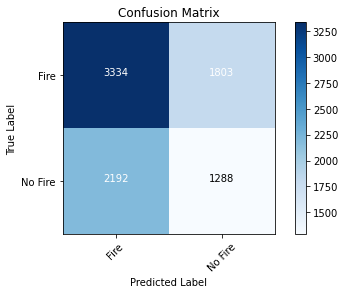

In [34]:
## Print the confusion matrix
cm = confusion_matrix(y_true=labels, y_pred=ypred)
cm_plot_labels = ['Fire','No Fire']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')